# Data Analysis Interview Challenge

In [530]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json

from datetime import datetime as dt

In [531]:
# set plot style
plt.rcParams['font.family'] = "serif"

# Part 1 - Exploratory data analysis

The attached logins.json file contains (simulated) timestamps of user logins in a particular geographic location. 

Aggregate these login counts based on 15 minute time intervals.

Visualize and describe the resulting time series of login counts in ways that best characterize the underlying patterns of the demand. 

Please report/illustrate important features of the demand, such as daily cycles. If there are data quality issues, please report them.

In [532]:
import os
cwd = os.getcwd()

In [533]:
# open json file in wrapper
l = open(f'{cwd}/data/logins.json')
# load json logins into python dict of login times
logins = json.load(l)

In [534]:
# create df for easier indexing
logins_df = pd.DataFrame.from_dict(logins)

In [535]:
# copy for later
logins_df1 = logins_df.copy()

In [536]:
logins_df.head(5)

login_time
0  1970-01-01 20:13:18
1  1970-01-01 20:16:10
2  1970-01-01 20:16:37
3  1970-01-01 20:16:36
4  1970-01-01 20:26:21

**Aggregate logins by 15 min time intervals.**

In [537]:
# aggregate logins based on 15 min time intervals
print(f"Login time min: {logins_df['login_time'].min()}") 
print(f"Login time max: {logins_df['login_time'].max()}")

Login time min: 1970-01-01 20:12:16
Login time max: 1970-04-13 18:57:38


In [538]:
logins_df['count'] = 1
logins_df['login_time'] = pd.to_datetime(logins_df['login_time'])

The json file had login_time times out of order. Potential data quality issue.

In [539]:
# sort login_time by time (earliest to latest)
sorted_logins = logins_df.sort_values(by='login_time').reset_index(drop=True)

In [540]:
sorted_logins.head(5)

login_time  count
0 1970-01-01 20:12:16      1
1 1970-01-01 20:13:18      1
2 1970-01-01 20:16:10      1
3 1970-01-01 20:16:36      1
4 1970-01-01 20:16:37      1

In [541]:
# sort values in original logins df
logins_df['login_time'] = sorted_logins['login_time']

In [542]:
logins_df.head(5)

login_time  count
0 1970-01-01 20:12:16      1
1 1970-01-01 20:13:18      1
2 1970-01-01 20:16:10      1
3 1970-01-01 20:16:36      1
4 1970-01-01 20:16:37      1

In [543]:
logins_df.rename(columns={'login_time':'login_interval'}, inplace=True)

In [544]:
logins_df.set_index('login_interval', inplace=True)

In [545]:
logins_df.head(5)

count
login_interval            
1970-01-01 20:12:16      1
1970-01-01 20:13:18      1
1970-01-01 20:16:10      1
1970-01-01 20:16:36      1
1970-01-01 20:16:37      1

In [546]:
# aggregate df into 15 min datetime index and counts
interval_idx = logins_df.groupby(pd.Grouper(axis=0, freq='15min')).sum()
interval_idx.head(5)

count
login_interval            
1970-01-01 20:00:00      2
1970-01-01 20:15:00      6
1970-01-01 20:30:00      9
1970-01-01 20:45:00      7
1970-01-01 21:00:00      1

In [547]:
# intervals without interval as index
intervals_df = interval_idx.copy().reset_index()
intervals_df['login_interval'] = pd.to_datetime(intervals_df['login_interval'])

intervals_df['date'] = intervals_df['login_interval'].dt.date
intervals_df['day'] = intervals_df['login_interval'].dt.day
# weekday - Monday=0, Sunday=6
intervals_df['weekday'] = intervals_df['login_interval'].dt.weekday
intervals_df['month'] = intervals_df['login_interval'].dt.month
intervals_df['time_interval'] = intervals_df['login_interval'].dt.time

intervals_df['num_logins'] = intervals_df['count']
intervals_df.drop(columns=['login_interval', 'count'], axis=0, inplace=True)

In [548]:
intervals_df.head(5)

date  day  weekday  month time_interval  num_logins
0  1970-01-01    1        3      1      20:00:00           2
1  1970-01-01    1        3      1      20:15:00           6
2  1970-01-01    1        3      1      20:30:00           9
3  1970-01-01    1        3      1      20:45:00           7
4  1970-01-01    1        3      1      21:00:00           1

In [549]:
# visualize and describe resulting time series to best characterize underlying pattern of demand 
#(when are there more or less logins)

clearly some cyclic pattern

In [550]:
num_by_day = intervals_df[['day', 'num_logins']].groupby('day').sum()
num_by_time = intervals_df[['time_interval', 'num_logins']].groupby('time_interval').sum()

In [551]:
num_by_time.head(5)

num_logins
time_interval            
00:00:00             1439
00:15:00             1547
00:30:00             1525
00:45:00             1482
01:00:00             1549

In [552]:
num_by_day.head(5)

num_logins
day            
1          3194
2          3044
3          3475
4          4037
5          3223

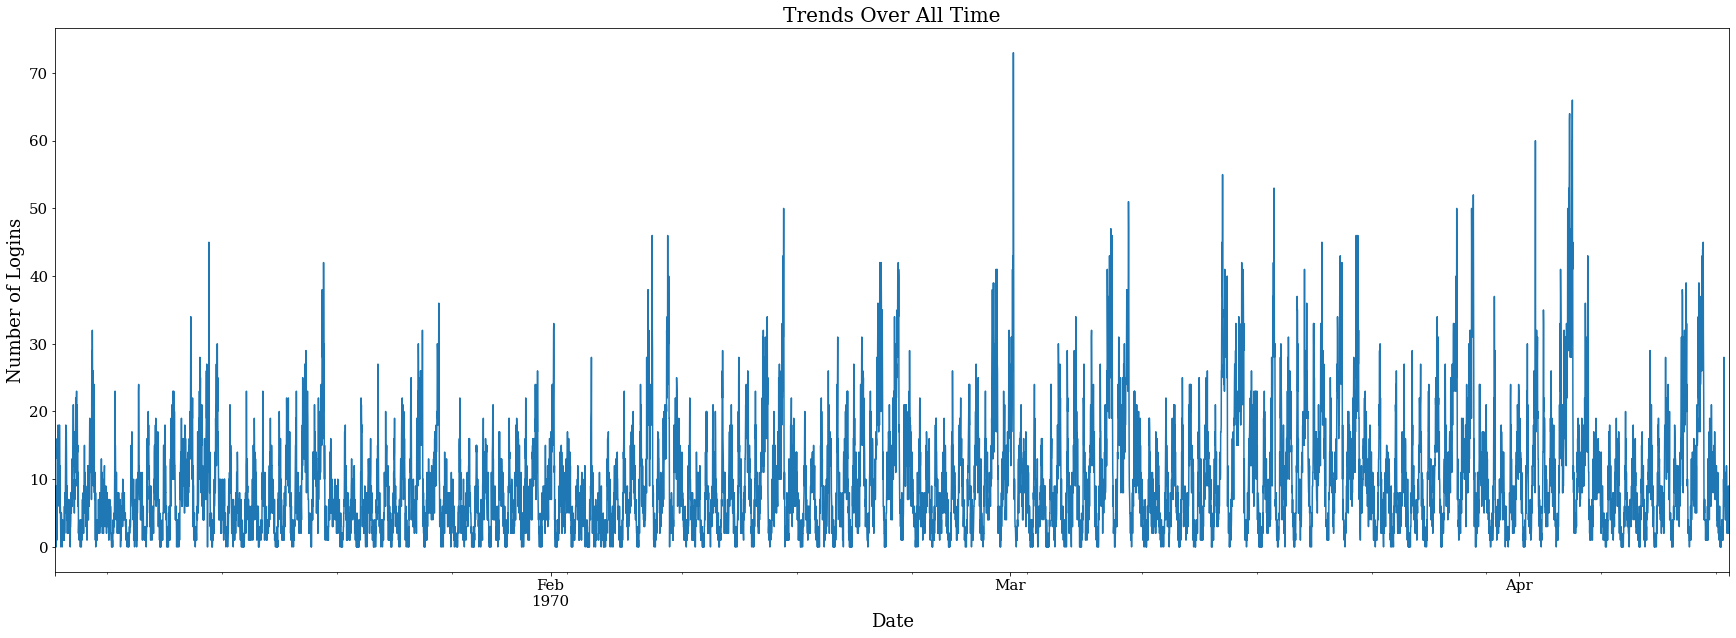

In [553]:
# loop through and plot each month - all dates 1970 - Jan - April
interval_idx.plot(y='count', figsize=(30,10), legend=None)
plt.title('Trends Over All Time', fontsize=20)
plt.xlabel('Date', fontsize=18)
plt.xticks(fontsize=15)
plt.ylabel('Number of Logins', fontsize=18)
plt.yticks(fontsize=15)
plt.show()

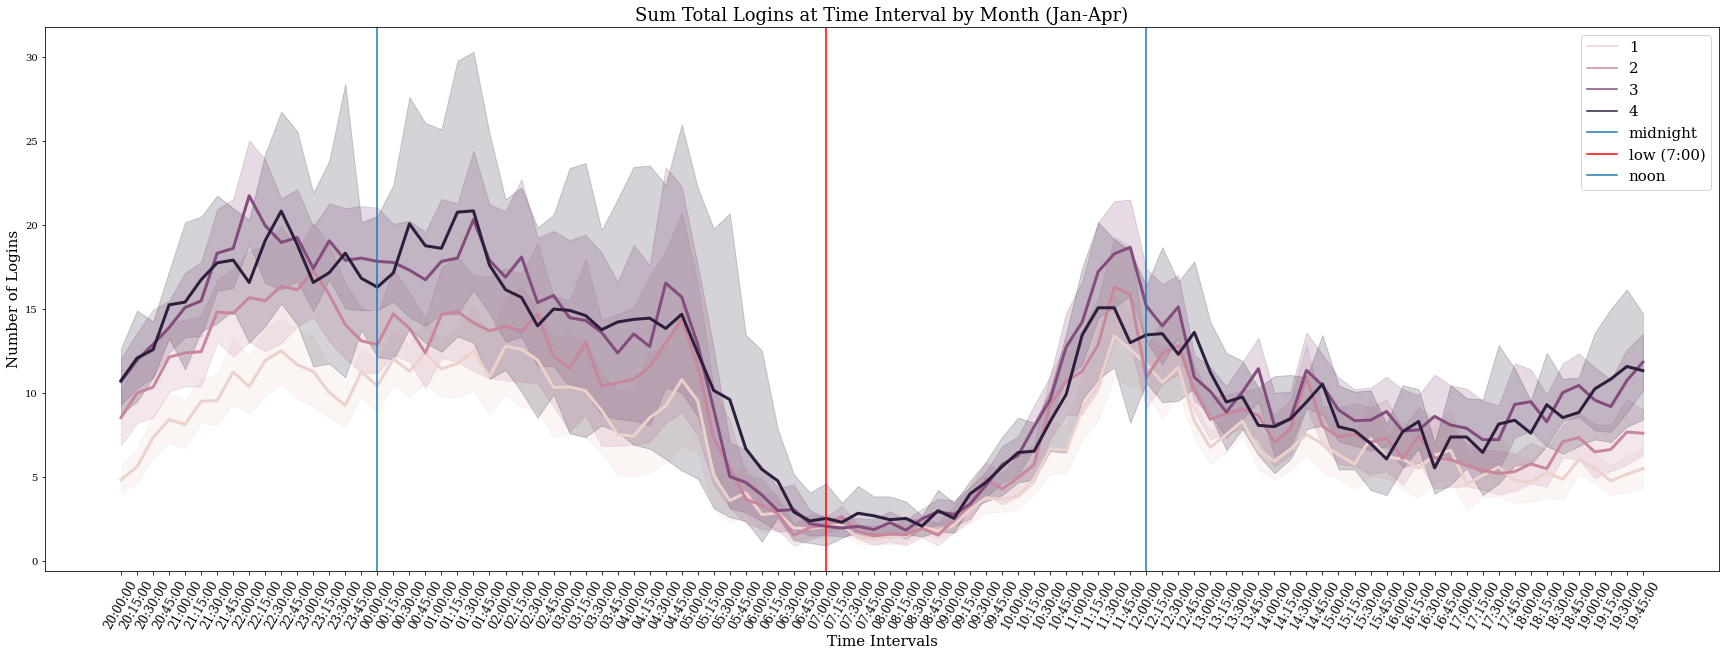

In [558]:
fig, ax = plt.subplots(figsize=(30,10))
sns.lineplot(data=intervals_df, x=intervals_df['time_interval'].astype(str),
                  y='num_logins', hue='month', ax=ax, linewidth=3)
plt.title('Sum Total Logins at Time Interval by Month (Jan-Apr)', fontsize=18)
plt.xlabel('Time Intervals', fontsize=15)
plt.xticks(num_by_time.index.astype(str), labels=num_by_time.index.astype(str), fontsize=12, 
           rotation=60)
plt.ylabel('Number of Logins', fontsize=15)
plt.axvline('00:00:00', label='midnight')
plt.axvline('07:00:00', label='low (7:00)', color='r')
plt.axvline('12:00:00', label='noon')
plt.legend(fontsize=15)
plt.show()

In [555]:
num_by_time.plot(figsize=(30,10), linewidth=3)
plt.title('Sum Total Logins at Each Time Interval (Jan-Apr)', fontsize=20)
plt.ylabel('Number of Logins', fontsize=18)
plt.yticks(fontsize=15)
plt.xlabel('Time of Day', fontsize=18)
plt.xticks(num_by_time.index.astype(str), labels=num_by_time.index.astype(str), rotation=60, fontsize=15)
plt.axvline('00:00:00', label='midnight')
plt.axvline('07:00:00', label='low (7:00)', color='r')
plt.axvline('12:00:00', label='noon')
plt.legend(fontsize=15)
plt.show()

The number of logins follows a daily cyclic pattern but number of logins at each time also increases as the months continue on.

Login counts decrease between roughly 5:00 and 8:00, increasing to end the lull in a peak at around 11:30.

The largest number of logins occur during roughly 20:00 and 5:00.

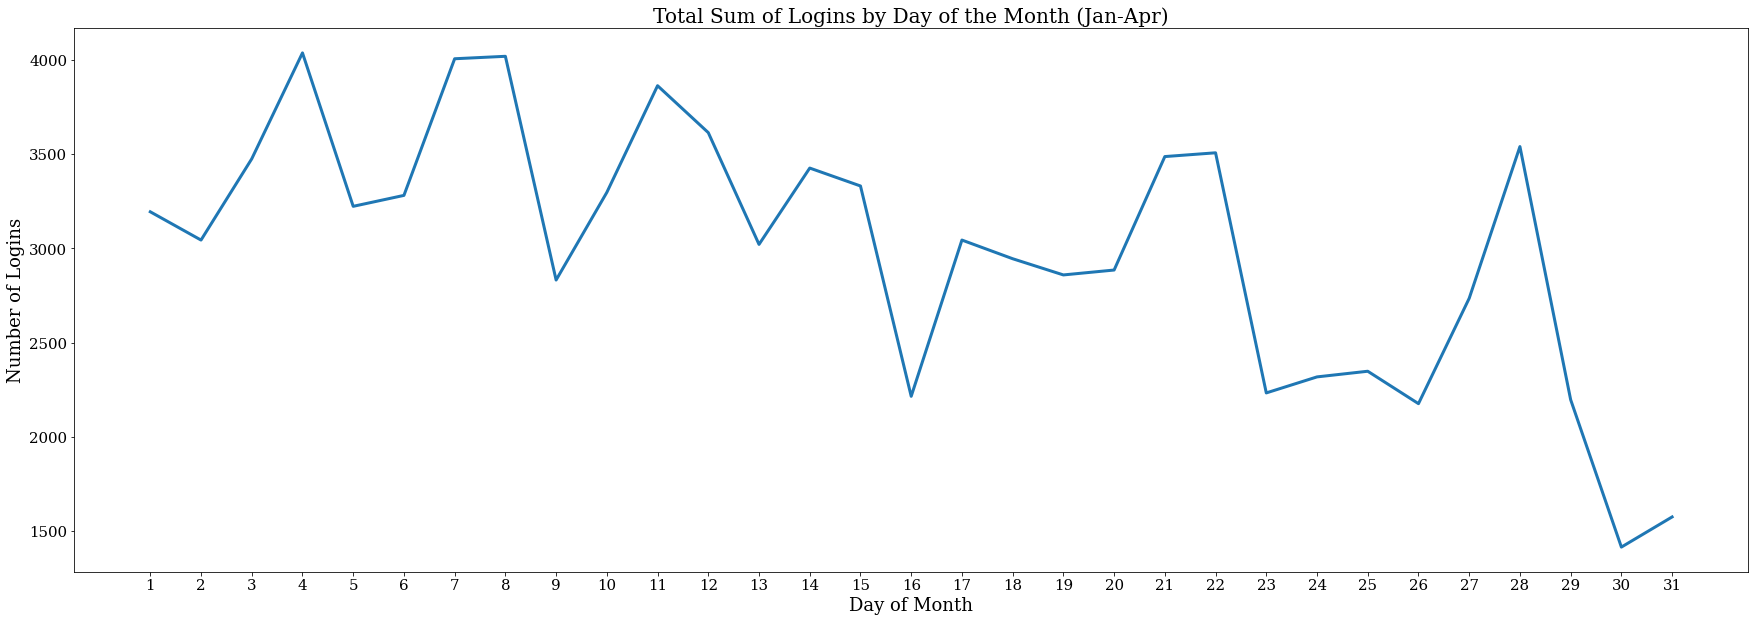

In [556]:
num_by_day.plot(legend=None, figsize=(30,10), linewidth=3)
plt.title('Total Sum of Logins by Day of the Month (Jan-Apr)', fontsize=20)
plt.ylabel('Number of Logins', fontsize=18)
plt.yticks(fontsize=15)
plt.xlabel('Day of Month', fontsize=18)
plt.xticks(num_by_day.index, labels=num_by_day.index.astype(str), fontsize=15)
plt.show()

Note: not all months have day 29-31

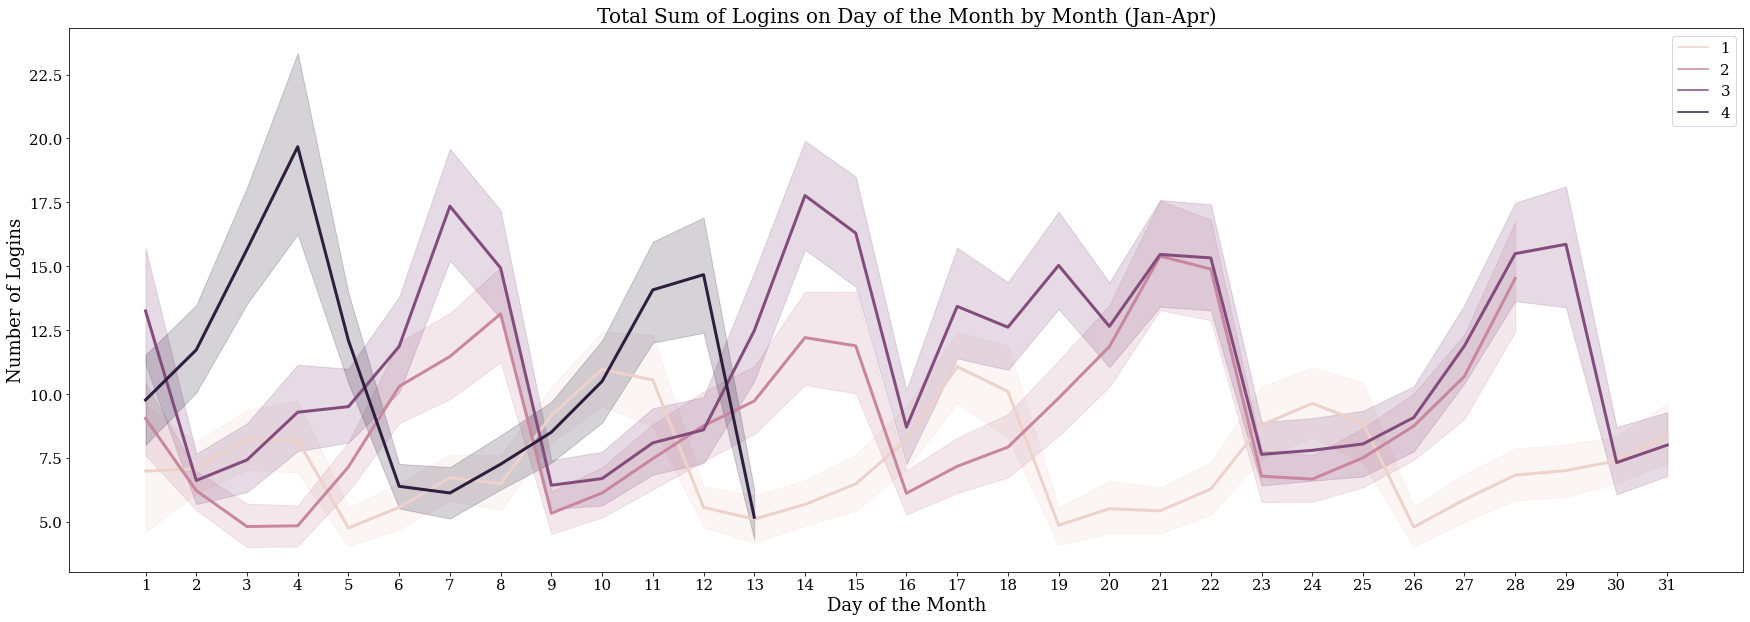

In [557]:
fig, ax = plt.subplots(figsize=(30,10))
sns.lineplot(data=intervals_df, x=intervals_df['day'].astype(str),
                  y='num_logins', hue='month', ax=ax, linewidth=3)
plt.title('Total Sum of Logins on Day of the Month by Month (Jan-Apr)', fontsize=20)
plt.xlabel('Day of the Month', fontsize=18)
plt.xticks(fontsize=15)
plt.ylabel('Number of Logins', fontsize=18)
plt.yticks(fontsize=15)
plt.legend(fontsize=15)
plt.show()

Appears to be a drop off toward the end of the month for March (3)

January has lower number of logins - could be less demand after holiday season

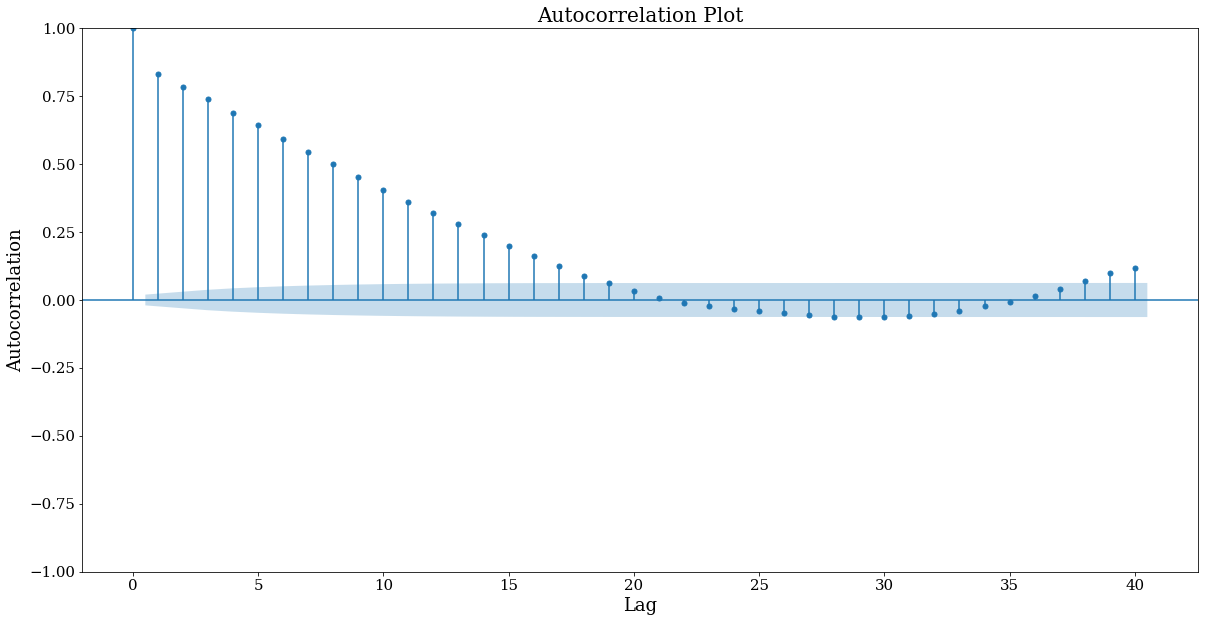

In [563]:
from statsmodels.graphics.tsaplots import plot_acf, month_plot

fig, ax = plt.subplots(figsize=(20,10))
plot_acf(interval_idx, ax=ax)
plt.title('Autocorrelation Plot', fontsize=20)
plt.xlabel('Lag', fontsize=18)
plt.xticks(fontsize=15)
plt.ylabel('Autocorrelation', fontsize=18)
plt.yticks(fontsize=15)
#plt.fill_between(y, 0.75, -0.75)
plt.show()

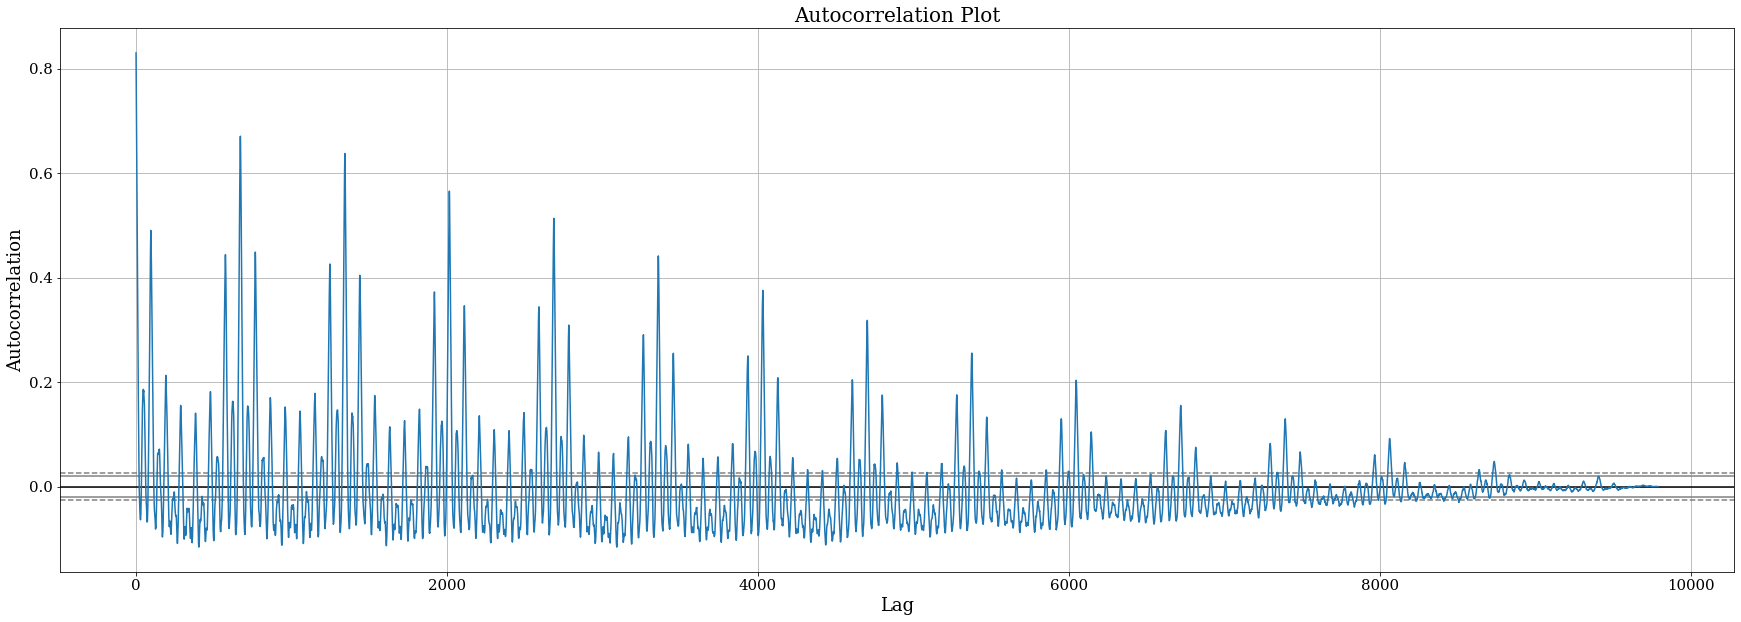

In [564]:
from pandas.plotting import autocorrelation_plot

fig, ax = plt.subplots(figsize=(30,10))
autocorrelation_plot(interval_idx, ax=ax)
plt.title('Autocorrelation Plot', fontsize=20)
plt.xlabel('Lag', fontsize=18)
plt.xticks(fontsize=15)
plt.ylabel('Autocorrelation', fontsize=18)
plt.yticks(fontsize=15)
plt.show()

In [565]:
# add days of the week column 1970-01-01 was a Thursday

intervals_df['date'] = pd.to_datetime(intervals_df['date'])
weekdays = []
for i in range(len(intervals_df)):
    date = intervals_df['date'][i]
    weekday = dt.weekday(date)
    weekdays.append(weekday)


In [566]:
intervals_df['weekday'] = weekdays

In [567]:
# map weekday numbers to names in new column
days = {0:'Monday', 1:'Tuesday', 2:'Wednesday', 3:'Thursday', 4:'Friday', 5:'Saturday', 6:'Sunday'}
intervals_df['day_of_week'] = intervals_df['weekday'].map(days)


In [568]:
intervals_df.head(5)

date  day  weekday  month time_interval  num_logins day_of_week
0 1970-01-01    1        3      1      20:00:00           2    Thursday
1 1970-01-01    1        3      1      20:15:00           6    Thursday
2 1970-01-01    1        3      1      20:30:00           9    Thursday
3 1970-01-01    1        3      1      20:45:00           7    Thursday
4 1970-01-01    1        3      1      21:00:00           1    Thursday

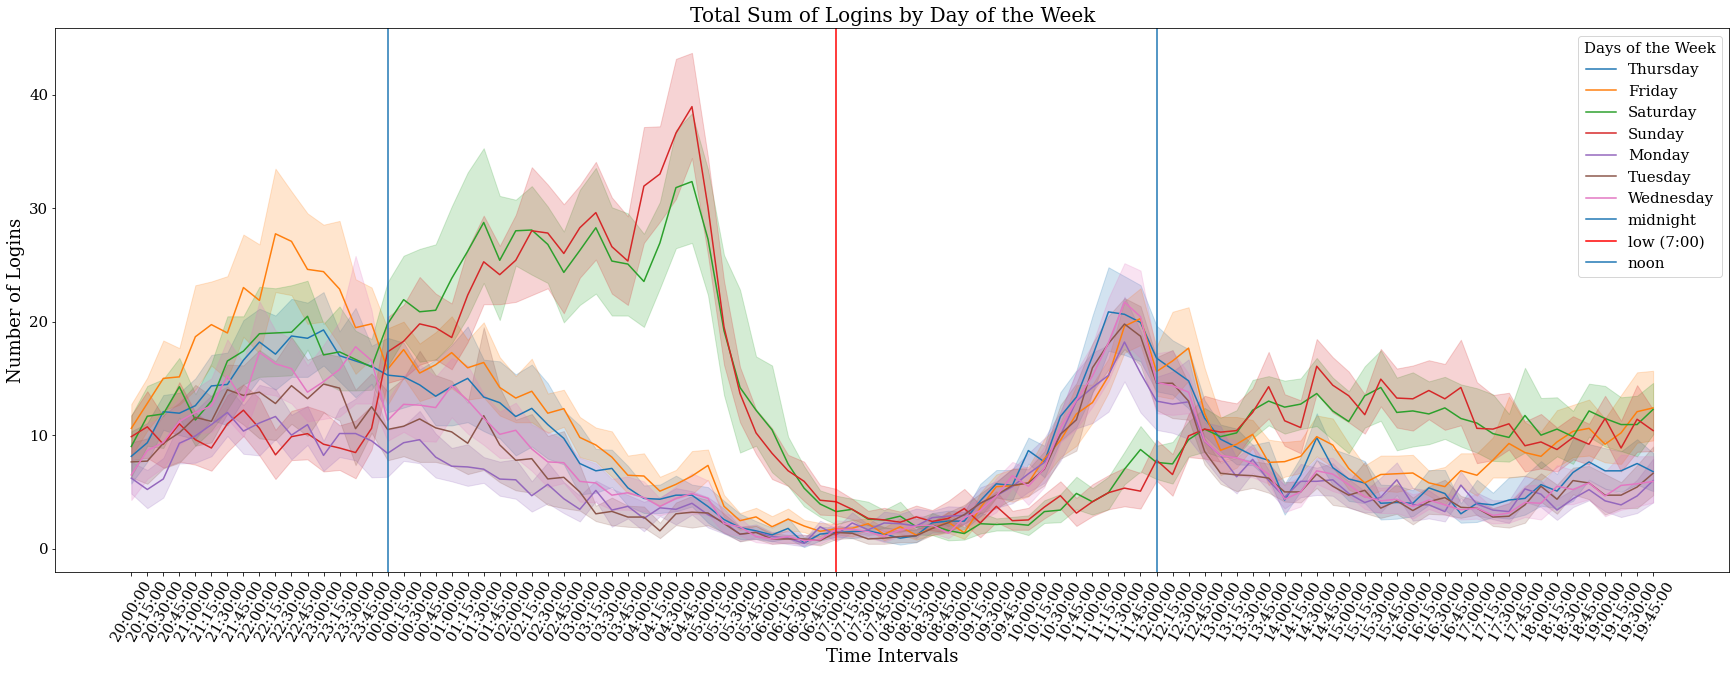

In [572]:
fig, ax = plt.subplots(figsize=(30,10))
sns.lineplot(data=intervals_df, x=intervals_df['time_interval'].astype(str),
                  y='num_logins', hue='day_of_week', ax=ax)
plt.title('Total Sum of Logins by Day of the Week', fontsize=20)
plt.xlabel('Time Intervals', fontsize=18, labelpad=4)
plt.xticks(fontsize=15, rotation=60)
plt.ylabel('Number of Logins', fontsize=18)
plt.yticks(fontsize=15)
plt.axvline('00:00:00', label='midnight')
plt.axvline('07:00:00', label='low (7:00)', color='r')
plt.axvline('12:00:00', label='noon')
plt.legend(title='Days of the Week', fontsize=15, title_fontsize=15)
plt.show()

The sum of logins differs by day of the week but the dip/lull in each day appears to be at similar times. 

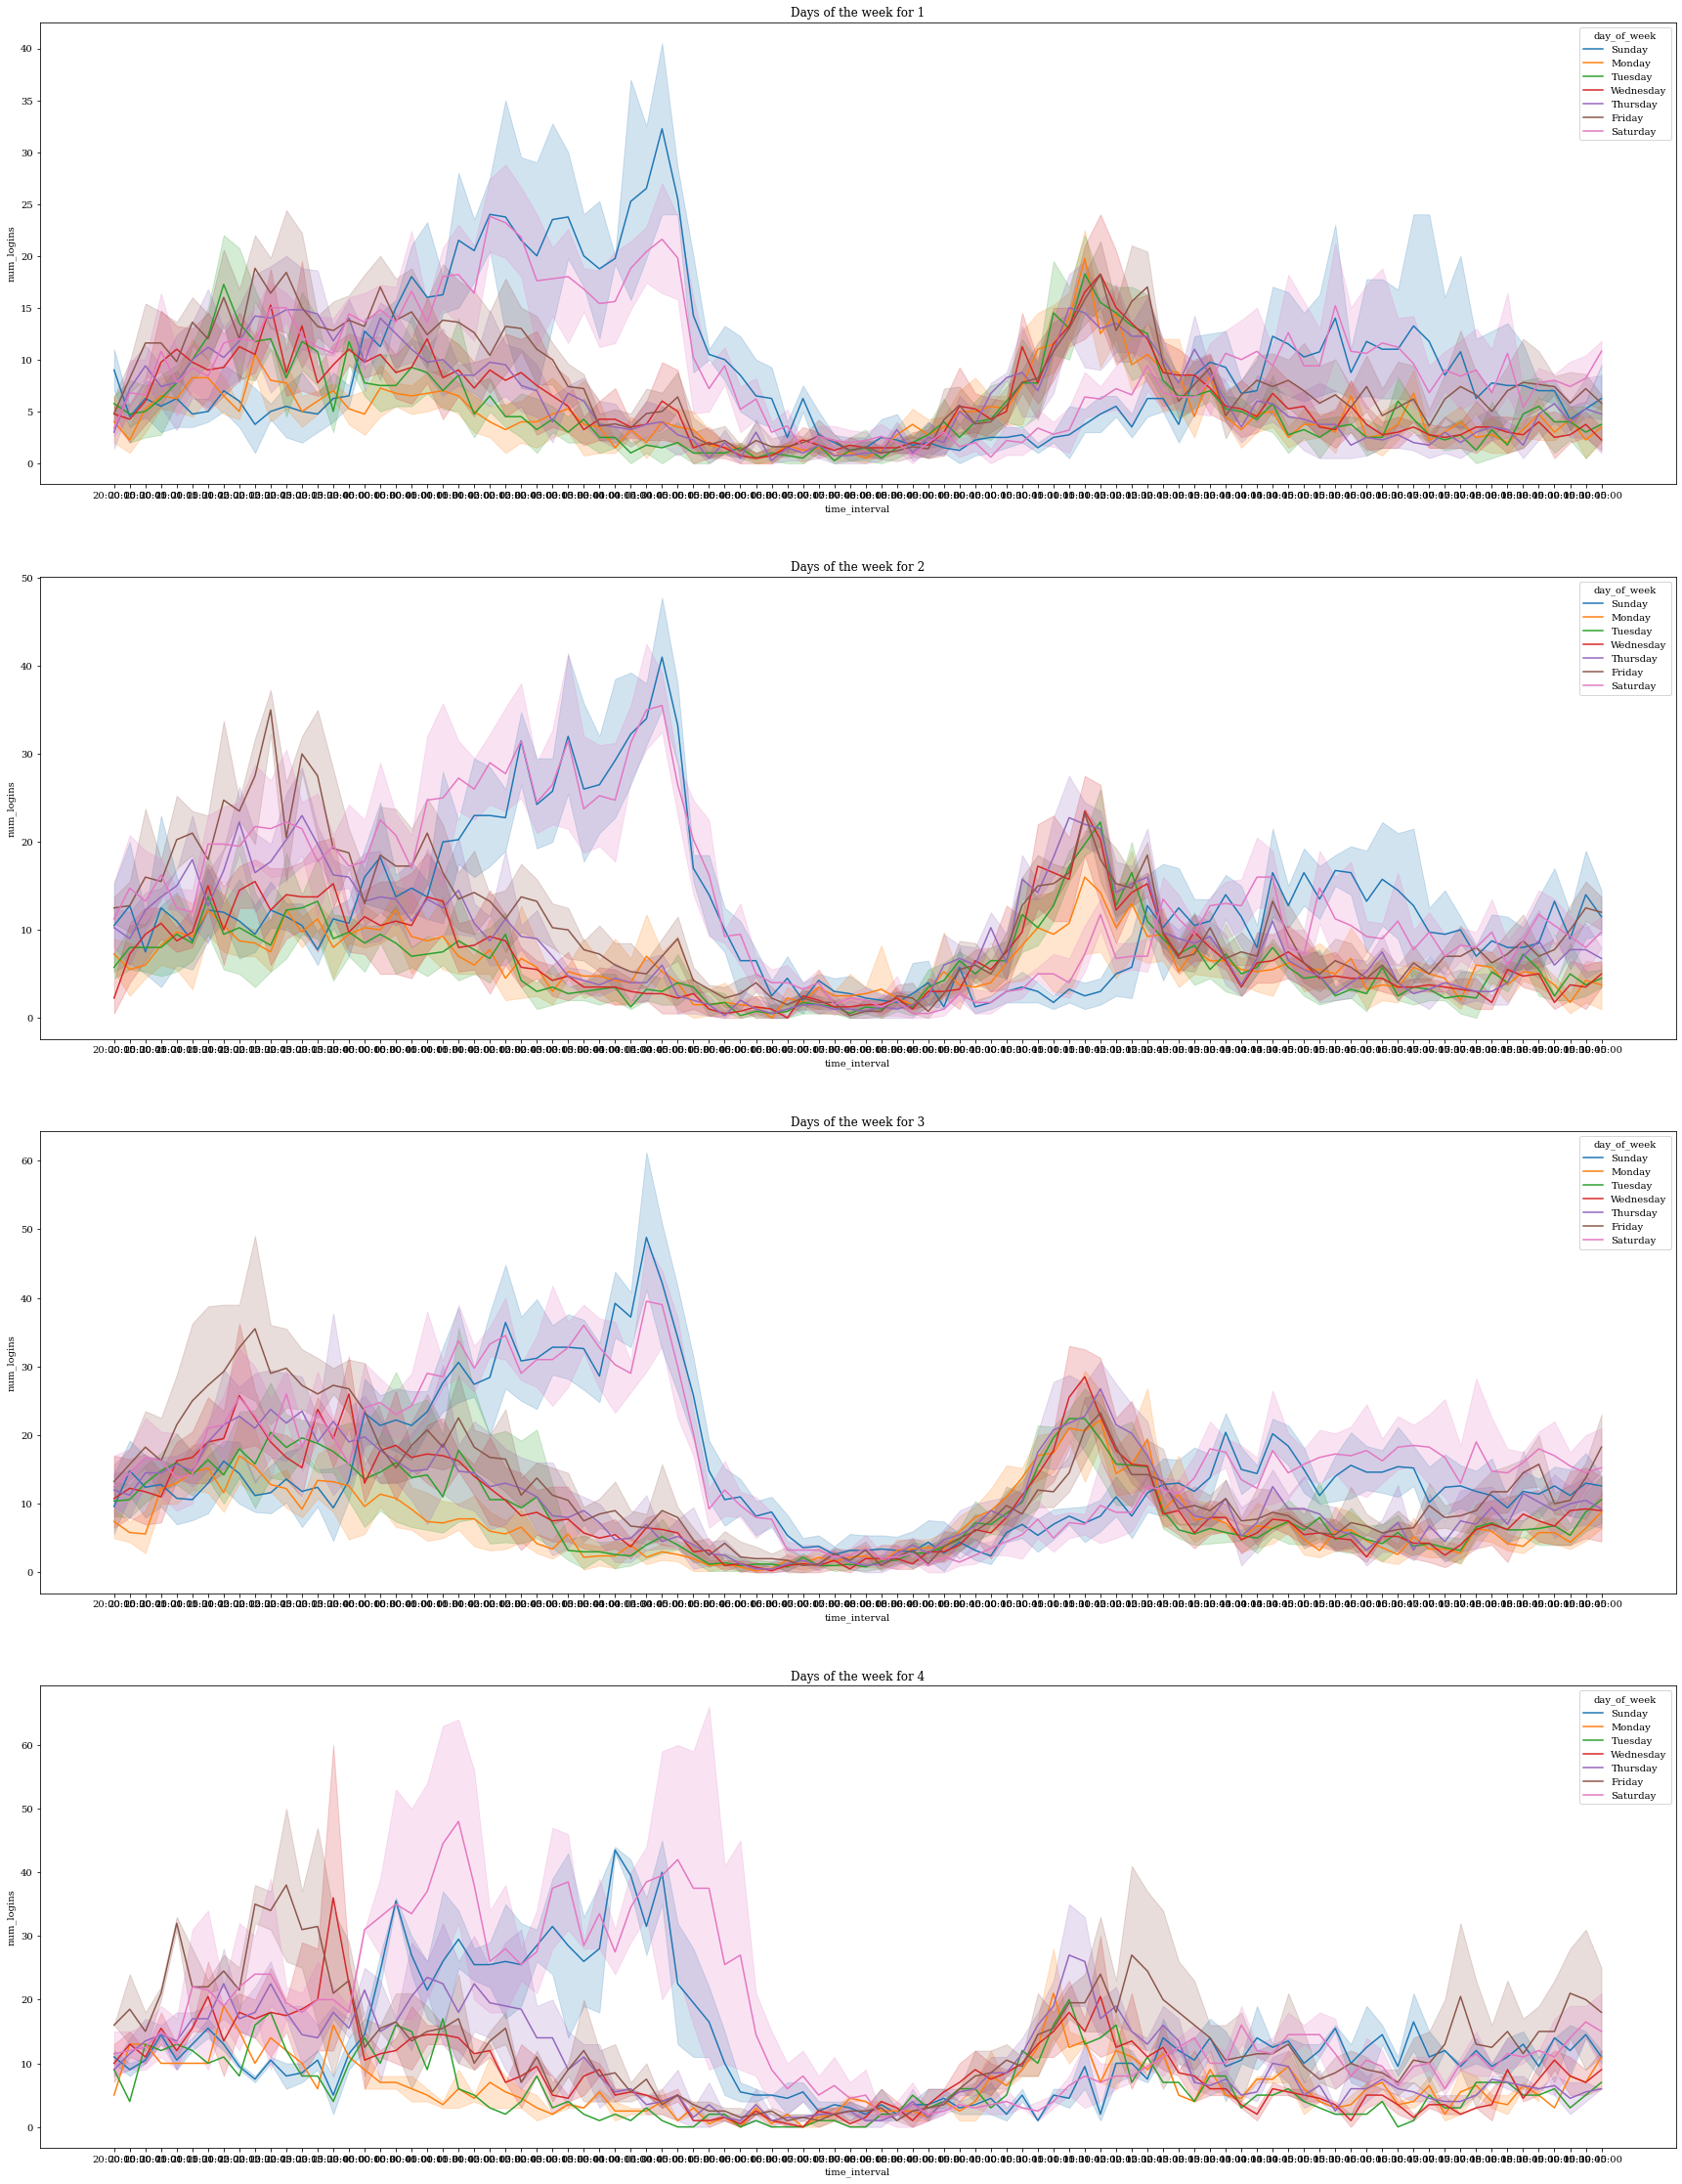

In [602]:
# Difference in day of week by month?
fig, axes = plt.subplots(4,1, figsize=(30,40))

for i in range(0,4):
    #data = intervals_df[intervals_df.month == i+1]
    #axis = i
    hue_order = ['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday']
    sns.lineplot(data=intervals_df[intervals_df.month == i+1].sort_values(by='day_of_week'), x=intervals_df['time_interval'].astype(str), 
                 y='num_logins', hue='day_of_week', hue_order=hue_order, ax=axes[i])
    axes[i].set_title(f"Days of the week for {i+1}")
    #axes[i].legend(labels=dotw)

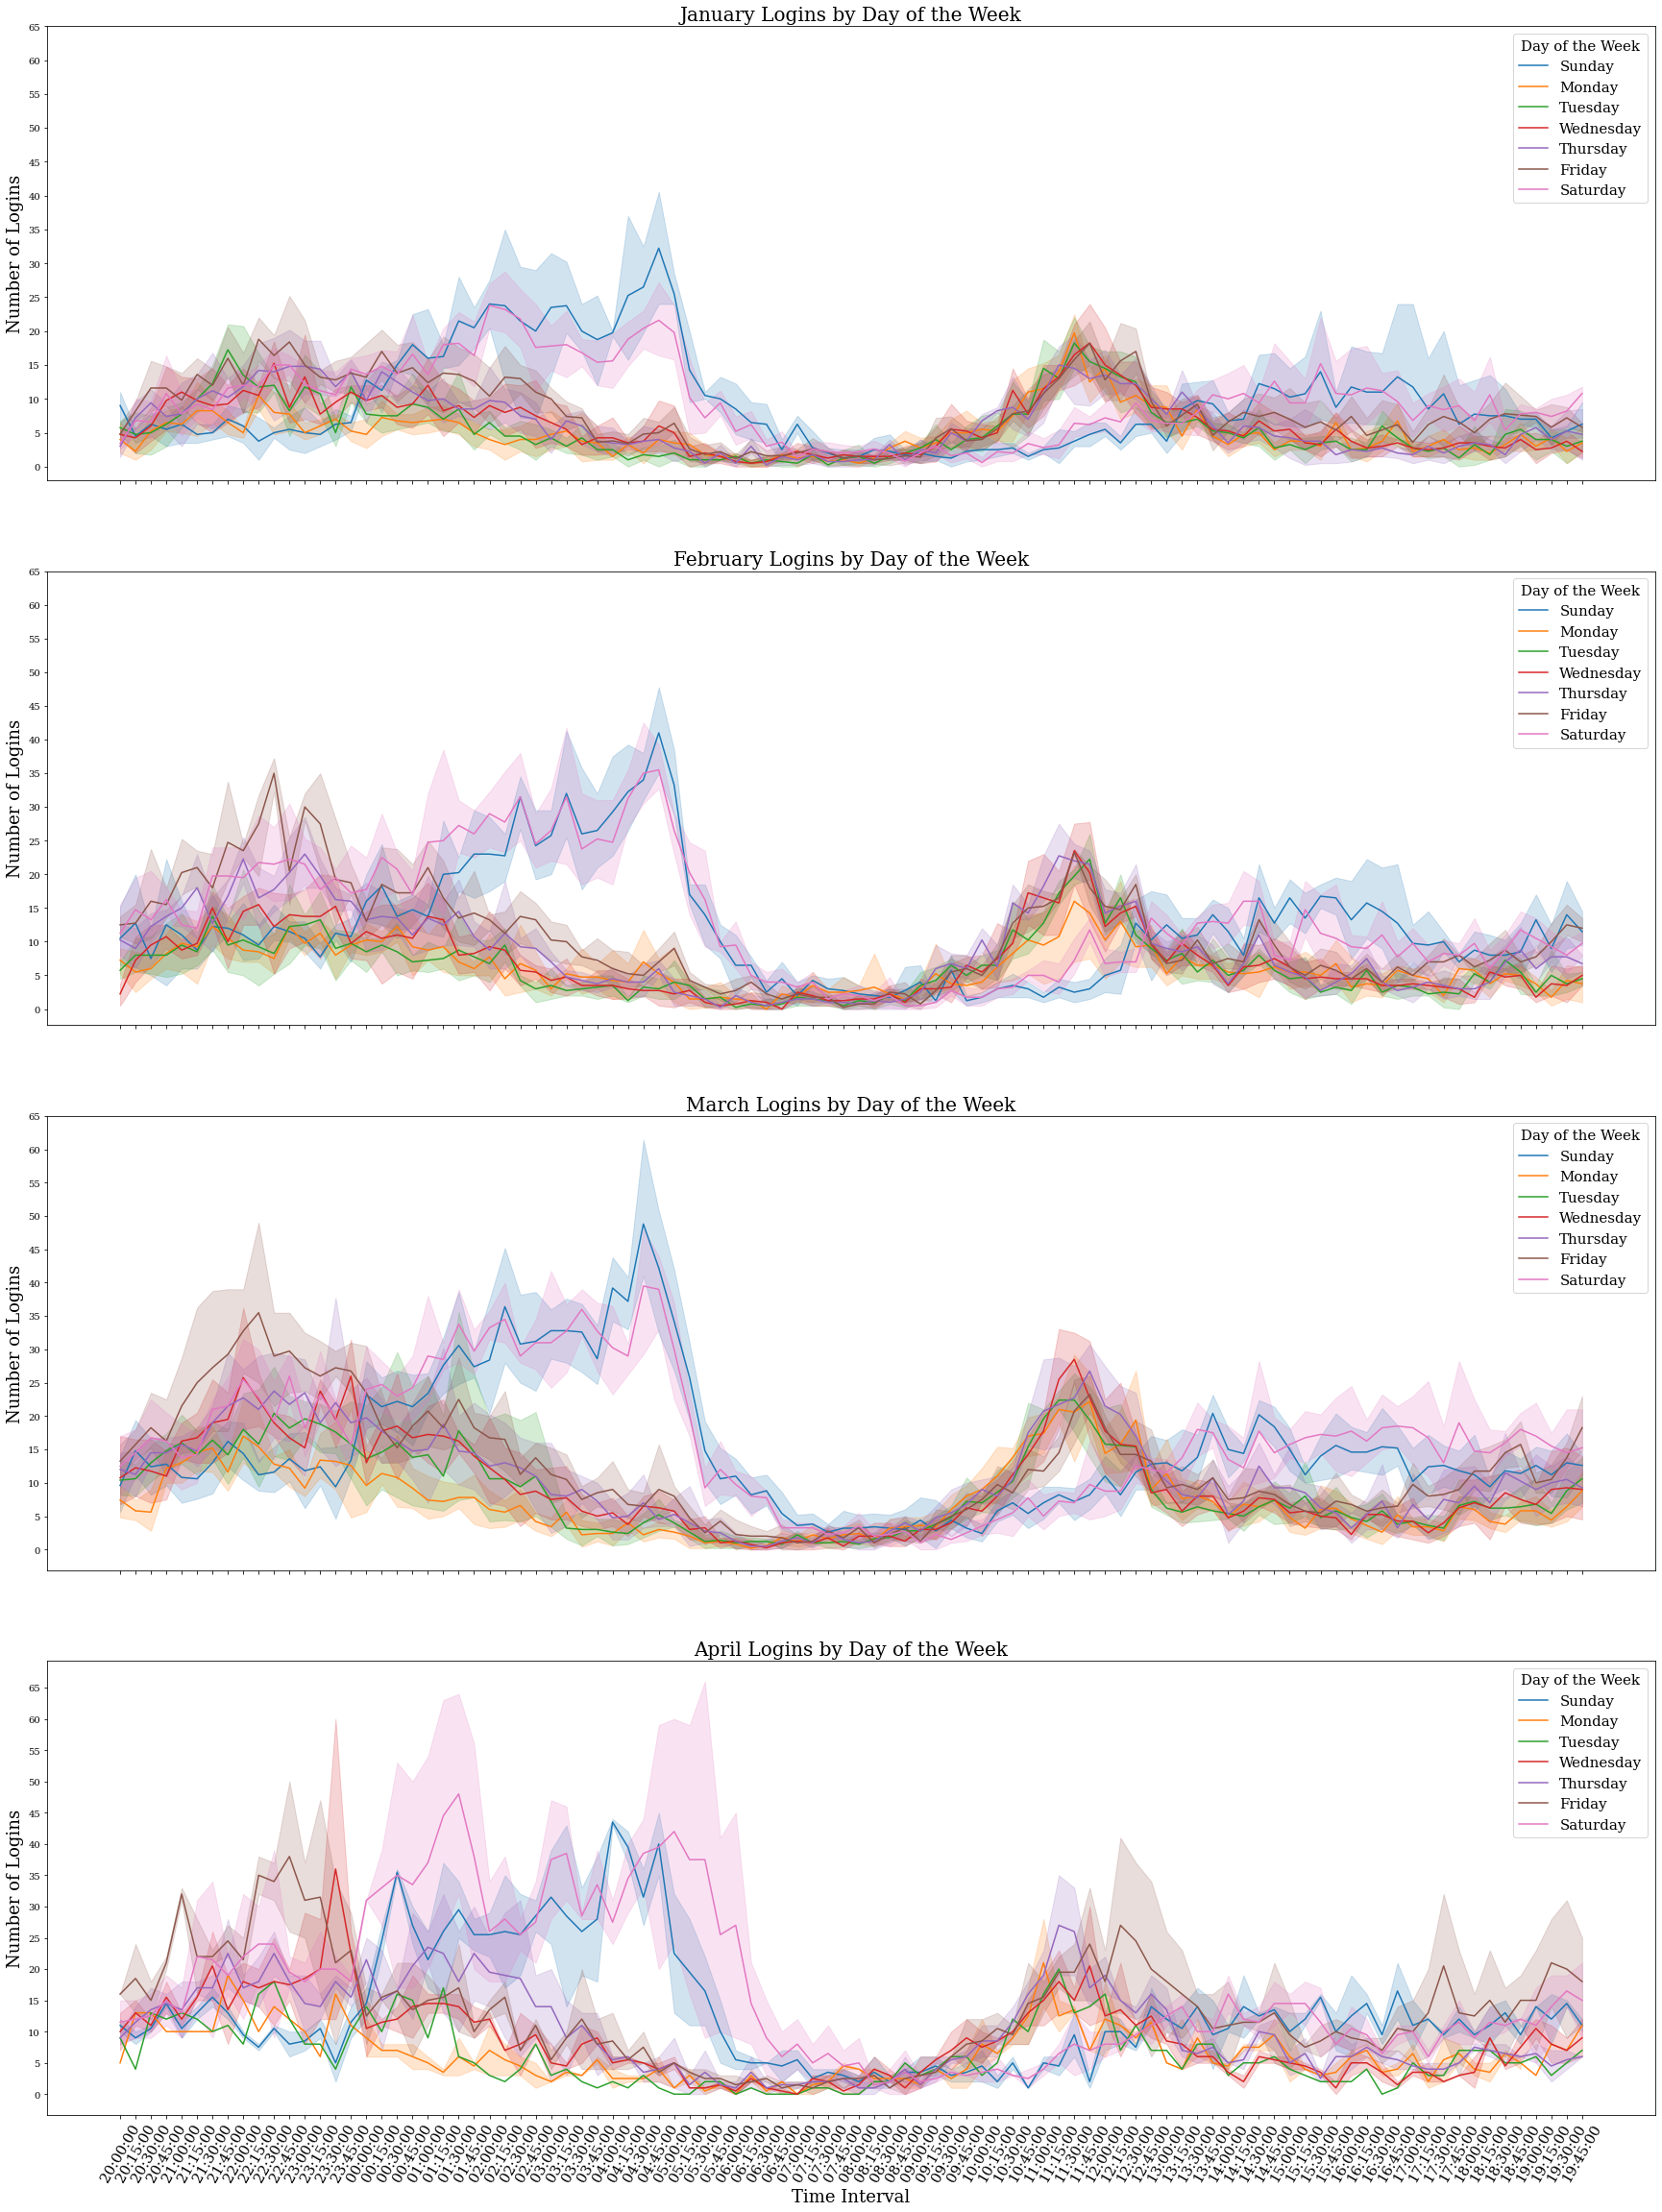

In [628]:
# Difference in most popular days of week by month?
fig, axes = plt.subplots(4,1, figsize=(30,40), sharex=True)

for i in range(0,4):
    months = {1:'January', 2:'February', 3:'March', 4:'April'}
    month = months[i+1]
    hue_order = ['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday']
    sns.lineplot(data=intervals_df[intervals_df.month == i+1], x=intervals_df['time_interval'].astype(str), 
                 y='num_logins', hue='day_of_week', hue_order=hue_order, ax=axes[i])
    axes[i].set_title(f"{month} Logins by Day of the Week", fontsize=20)
    axes[i].set_xlabel('Time Interval', fontsize=18)
    axes[i].set_ylabel('Number of Logins', fontsize=18)
    axes[i].set_yticks([0,5,10,15,20,25,30,35,40,45,50,55,60,65], fontsize=18)
    axes[i].set_xticks(num_by_time.index.astype(str), labels=num_by_time.index.astype(str), rotation=60, fontsize=15)
    axes[i].legend(title='Day of the Week', fontsize=15, title_fontsize=15)

Daily cycle differs somewhat between days of the week. 
A greater number of total logins occurred between 00:00 (midnight) to 5:00 on Saturday and Sunday, compared to the rest of the dyas of the week.
A greater number of total logins occurred between 9:00 to 12:00 (noon) on weekdays.

Could possibly be due to a difference in sleep schedule? 

Does appear to be difference in number of logins per month and which days are more popular by month

# Part 2 - Experiment and metrics design

The neighboring cities of Gotham and Metropolis have complementary circadian rhythms: on weekdays, Ultimate Gotham is most active at night, and Ultimate Metropolis is most active during the day. On weekends, there is reasonable activity in both cities.
However, a toll bridge, with a two way toll, between the two cities causes driver partners to tend to be exclusive to each city. The Ultimate managers of city operations for the two cities have proposed an experiment to encourage driver partners to be available in both cities, by reimbursing all toll costs.

1) What would you choose as the key measure of success of this experiment in encouraging driver partners to serve both cities, and why would you choose this metric?

2) Describe a practical experiment you would design to compare the effectiveness of the proposed change in relation to the key measure of success. Please provide details on:

a) how you will implement the experiment

b) what statistical test(s) you will conduct to verify the significance of the observation

c) how you would interpret the results and provide recommendations to the city operations team along with any caveats.
Note: The two cities of Gotham and Metropolis are not in the provided dataset; however, you do not need this information to answer Part 2.

In [ ]:
# managers want to encourage drivers to be available in both cities by reimbursig all toll costs

# how much would that cost vs the money the company is making?

#A key measure of success in this experiment would be a percentage increase in drivers crossing the toll bridge 
#during the night/day and how much profit was made after subtracting cost of reimbursing tolls


In [ ]:
On weekends, the two cities are reasonably similar in activity. If Ultimate Metropolis is most active during the day, 
How many Ultimate Gotham drivers were taking rides in Ultimate Metropolis during the day, since Ultimate Gotham 
is most active at night and Ultimate Metropolis is most active during the day. 

People driving full time would have more of an incentive to come from Ultimate Gotham to Metropolis during the day, 
but Metropolis drivers will have a good amount of rides during the day and the evening. 
Enough that they may not be as incentivized. 

In [ ]:
could count drivers taking rides in other city as "conversion rate"
cost per acquisition (cost of tolls)
growth rate (how many more rides completed)

does cost of rides increase with more availability of drivers into the other city? 
or number of rides completed increase?

how much is the toll?

Does this result in new drivers? Does this result in existing drivers doing more rides? 
Does this increase ride availability to people farther away and so they take more expensive rides between cities?

In [ ]:
Null hypothesis:
Alternate hypothesis:

Statistical test for significance:


# Part 3 - Predictive modeling

Ultimate is interested in predicting rider retention. To help explore this question, we have provided a sample dataset of a cohort of users who signed up for an Ultimate account in January 2014. The data was pulled several months later; we consider a user retained if they were “active” (i.e. took a trip) in the preceding 30 days.
We would like you to use this data set to help understand what factors are the best predictors for retention, and offer suggestions to operationalize those insights to help Ultimate.
The data is in the attached file ultimate_data_challenge.json. See below for a detailed description of the dataset. Please include any code you wrote for the analysis and delete the dataset when you have finished with the challenge.
1. Perform any cleaning, exploratory analysis, and/or visualizations to use the provided data for this analysis (a few sentences/plots describing your approach will suffice). What fraction of the observed users were retained?
2. Build a predictive model to help Ultimate determine whether or not a user will be active in their 6th month on the system. Discuss why you chose your approach, what alternatives you considered, and any concerns you have. How valid is your model? Include any key indicators of model performance.
3. Briefly discuss how Ultimate might leverage the insights gained from the model to improve its long term rider retention (again, a few sentences will suffice).

Data description

● city: city this user signed up in

● phone: primary device for this user

● signup_date: date of account registration; in the form ‘YYYYMMDD’

● last_trip_date: the last time this user completed a trip; in the form ‘YYYYMMDD’

● avg_dist: the average distance in miles per trip taken in the first 30 days after signup

● avg_rating_by_driver: the rider’s average rating over all of their trips

● avg_rating_of_driver: the rider’s average rating of their drivers over all of their trips

● surge_pct: the percent of trips taken with surge multiplier > 1

● avg_surge: The average surge multiplier over all of this user’s trips

● trips_in_first_30_days: the number of trips this user took in the first 30 days after signing up

● ultimate_black_user: TRUE if the user took an Ultimate Black in their first 30 days; FALSE otherwise

● weekday_pct: the percent of the user’s trips occurring during a weekday

In [ ]:
# goals -- understand what factors are best predictors for retention
# offer suggesions to operationalize those insights

# Perform any cleaning, exploratory analysis, and/or visualizations to use the provided data for this analysis 
# (a few sentences/plots describing your approach will suffice)
# What fraction of the observed users were retained?


# these users signed up in Jan 2014

In [ ]:
# load json into python dict of challenge data
d = open(f'{cwd}/data/ultimate_data_challenge.json')
challenge_data = json.load(d)

In [ ]:
data_df = pd.DataFrame.from_dict(challenge_data)

In [ ]:
data_df.head(5)

In [ ]:
data_df.info()

In [ ]:
data_df.describe()

In [ ]:
data_df.isna().sum()

In [ ]:
# make date columns type datetime
data_df['signup_date'] = pd.to_datetime(data_df['signup_date'])
data_df['last_trip_date'] = pd.to_datetime(data_df['last_trip_date'])

In [ ]:
print(f"The most recent 'last_trip_date' is: {data_df['last_trip_date'].max()}")
# only january signups
print(f"The most recent 'signup_date' is {data_df['signup_date'].max()}")

In [ ]:
# identify "active users" -- have used in last 30 days
active_user = []

for i in range(len(data_df)):
    last_trip = data_df['last_trip_date'][i]
    d = pd.to_datetime('2014-06-01')
    if last_trip >= d:
        active_user.append(True)
    else:
        active_user.append(False)

# make bool active user column

In [ ]:
data_df['active_user'] = active_user

In [ ]:
data_df.head(5)

In [ ]:
# What fraction of the observed users were retained?

print('Active User Value Counts (Used in the last 30 days):')
print(f"True: {(data_df['active_user'] == True).sum()} -- {round((data_df['active_user'] == True).sum()/len(data_df),3)*100}%")
print(f"False: {(data_df['active_user'] == False).sum()} -- {round((data_df['active_user'] == False).sum()/len(data_df),3)*100}%")

In [ ]:
# 8122 did not rate their driver (avg_rating_of_driver)
did_not_rate = data_df[data_df['avg_rating_of_driver'].isna()]
did_rate = data_df[~data_df['avg_rating_of_driver'].isna()]

In [ ]:
# explore riders that did not rate driver
print(f"{round(len(active_did_not_rate)/len(did_not_rate),2)*100}% of riders that did not rate their driver were retained.")

print(f"{round(len(active_did_rate)/len(did_rate),2)*100}% of riders that did rate their driver were retained.")


In [ ]:
# 1632 active users did not rate their driver
active_did_not_rate = did_not_rate[did_not_rate['active_user'] == True]
active_did_rate = did_rate[did_rate['active_user'] == True]

Rating driver may be predictor. 

**Visualizations**

In [ ]:
# exploratory plotting
data_df.nunique()

In [ ]:
print('City Percentages')
round(data_df['city'].value_counts()/len(data_df)*100, 2)

In [ ]:
no_first_30_trips = data_df[data_df['trips_in_first_30_days'] == 0]
print(f"{round(len(no_first_30_trips)/len(data_df), 2)*100}% of January signups had 0 trips in the first 30 days.")

inactive_no_first_30_trips = no_first_30_trips[no_first_30_trips['active_user']==False]

In [ ]:
print(f"Of riders with 0 trips in their first 30 days, {round(len(inactive_no_first_30_trips)/len(no_first_30_trips),2)*100}% were not retained. {100-round(len(inactive_no_first_30_trips)/len(no_first_30_trips),2)*100}% were retained.")

Could support incentivizing taking a ride within the first 30 days. 

**Plot Distributions**

In [ ]:
columns = [['city', 'phone'], ['avg_surge', 'surge_pct'],['avg_rating_of_driver', 'avg_rating_by_driver'],
           ['signup_date','last_trip_date'], ['ultimate_black_user', 'avg_dist'], ['active_user', 'trips_in_first_30_days']]

def countplots(cols):
    fig, axes = plt.subplots(6, 2, figsize=(20, 40), squeeze=True)
    fig.suptitle('Countplots',y=1)
    for row in range(6):
        for col in range(2):
            column = cols[row][col]
            p = sns.countplot(x=data_df[column],ax=axes[row,col], order=data_df.sort_values(by=column)[column].unique())
            p.set_xticks(range(len(data_df[column].unique())))
            p.set_xticklabels(labels=data_df.sort_values(by=column)[column].unique(), rotation=30)
            axes[row,col].set_title(f'{column.capitalize()} Counts')
    plt.subplots_adjust(wspace=0.4, hspace=0.4)
    plt.tight_layout()
    plt.show()
    
countplots(columns)

First impressions from plots -- 

More riders travel shorter distances, similar proportions of T/F for ultimate_black_user and active_user. 

There's a cyclic pattern to signup date counts and last trip date counts.
Most common rating of drivers and by drivers was 5.0. 

In [ ]:
# retention based on rating
rated_5_by_rider = data_df[data_df['avg_rating_of_driver'] == 5.0]
rated_5_by_driver = data_df[data_df['avg_rating_by_driver'] == 5.0]
print(f"Of riders who rated their driver, {round(len(rated_5_by_rider)/len(did_rate)*100,2)}% rated their driver a 5.0 avg. Ultimate retained {round(len(rated_5_by_driver)/len(rated_by_driver)*100,2)}% of these riders.")

rated_by_driver = data_df[~data_df['avg_rating_by_driver'].isna()]
ret_rbd  = rated_by_driver[rated_by_driver['active_user'] == True]
print(f"Of riders who were rated by a driver, {round((len(rated_5_by_driver)/len(rated_by_driver)*100),2)}% were rated a 5.0 avg. Ultimate retained {round(len(ret_rbd)/len(rated_by_driver)*100,2)}% of these riders.")


Having a good driver may be a stronger indicator of retention than being rated well by that driver. 

**Time-Series Distributions**

In [ ]:
# signup date vs last trip date

# plot all against time 

In [ ]:
# (a few sentences/plots describing your approach will suffice)


37.6% of users were retained. Just under 19,000 ( users whose last ride was within 30 days of the most recent date, between 2014-06-01 and 2014-07-01. 

In [ ]:
# Build a predictive model to help Ultimate determine whether or not a user will be active in their 6th month on the system. 


# Discuss why you chose your approach, what alternatives you considered, and any concerns you have. 
# How valid is your model? Include any key indicators of model performance.

In [ ]:

# Discuss why you chose your approach, what alternatives you considered, and any concerns you have. 
# How valid is your model? Include any key indicators of model performance.